## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 70 kB 8.8 MB/s 
     |████████████████████████████████| 1.1 MB 47.2 MB/s 
     |████████████████████████████████| 112 kB 50.1 MB/s 
     |████████████████████████████████| 288 kB 54.3 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 57.6 MB/s 
     |████████████████████████████████| 144 kB 51.8 MB/s 
     |████████████████████████████████| 749 kB 43.9 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169004, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 1000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 1000 steps
Generated time-series
Normalized 'candles_norm' with shape : (1000, 9)
Feature data 'x_candles' with size : 952
Feature data with time intervals 'x_time' with size : 952


In [6]:
USE_PRETRAINED = True
PRESAVED_MODELDATE='220615_18_16'
initial_timestamp = pd.Timestamp(datetime.strptime('220615_18_16', '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.0)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
preds = ts_btc.denorm(loaded_model.preds)

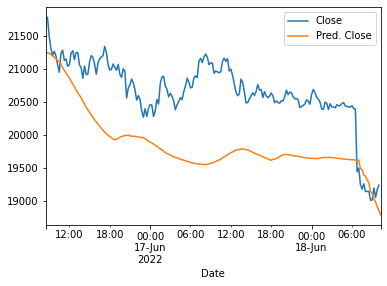

In [9]:
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_preds_true.iloc[-200:].plot()

In [8]:
def backtest(df_preds_true, short_or_long = "long", fee=0.025):

    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0

    for i in range(split_point, len(true_vals) - step_back):
        predicted_close = preds[i - split_point]
        previous_close = true_vals[i]
        real_next_close = true_vals[i+1]

        if (previous_close + (previous_close * fee)) < predicted_close:  # buy
            profit = real_next_close - previous_close
            if profit > 0:
                profit = profit - (profit * fee)
                buys_cnt_win += 1
                old_profit_negative = False
            else:
                profit = profit + (profit * fee)
                buys_cnt_losses += 1
                if old_profit_negative:
                    old_profits += profit
                else:
                    old_profits = profit
                if old_profits < drawback:
                    drawback = old_profits
                old_profit_negative = True
            wallet += profit
            total_wallet_history.append(wallet)
            single_wallet_history.append(profit)
            buys_cnt += 1
        else:
            old_profit_negative = False
            old_profits = 0

    # print('Fee:', fee)
    # print('----------------------')
    # print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    # print('Wallet  ', wallet)
    # print('Drawback', drawback)

    return total_wallet_history, single_wallet_history, wallet

In [ ]:
def backtest_df(df_preds_true, long_or_short = "long", fee=0.025):

    if long_or_short == "short":
            long = True
    elif long_or_short == "long":
            long = False
    else:
        raise ValueError("Can only have long or short")

    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0

    previous_true_close = df_preds_true.dropna().iloc[0,0]
    previous_pred_close = df_preds_true.dropna().iloc[0,1]

    for index, row in df_preds_true.dropna().iloc[1:].iterrows():
        true_close = row[0]
        pred_close = row[1]

        if long:
            if previous_true_close * (1+fee) < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

            previous_true_close = true_close
            previous_pred_close = pred_close

        else:
            if  previous_true_close * (1. + fee) > pred_close:  # short
                profit = true_close - previous_true_close
                if profit < 0:
                    # win
                    profit = -1*(profit - (profit * fee))
                    buys_cnt_win += 1
                    old_profit_negative = False
                else:
                    #loss
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

            previous_true_close = true_close
            previous_pred_close = pred_close
    
    # print('Fee:', fee)
    # print('----------------------')
    # print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    # print('Wallet  ', wallet)
    # print('Drawback', drawback)

    return total_wallet_history, single_wallet_history, wallet

In [19]:
df_preds_true.dropna().iloc[0]

Close          30211.480000
Pred. Close    29535.818502
Name: 2022-06-08 12:31:00, dtype: float64

In [17]:
for index, row in df_preds_true.dropna().iterrows():
    print(index, row[0])

2022-06-08 12:31:00 30211.48
2022-06-08 12:46:00 30137.78
2022-06-08 13:01:00 30310.92
2022-06-08 13:16:00 30369.54
2022-06-08 13:31:00 30496.59
2022-06-08 13:46:00 30766.49
2022-06-08 14:01:00 30523.11
2022-06-08 14:16:00 30503.52
2022-06-08 14:31:00 30351.84
2022-06-08 14:46:00 30425.75
2022-06-08 15:01:00 30550.84
2022-06-08 15:16:00 30480.05
2022-06-08 15:31:00 30405.1
2022-06-08 15:46:00 30476.77
2022-06-08 16:01:00 30537.87
2022-06-08 16:16:00 30439.94
2022-06-08 16:31:00 30232.51
2022-06-08 16:46:00 30331.51
2022-06-08 17:01:00 30350.3
2022-06-08 17:16:00 30384.54
2022-06-08 17:31:00 30376.78
2022-06-08 17:46:00 30382.62
2022-06-08 18:01:00 30334.29
2022-06-08 18:16:00 30212.5
2022-06-08 18:31:00 30193.53
2022-06-08 18:46:00 30234.87
2022-06-08 19:01:00 30148.83
2022-06-08 19:16:00 30229.63
2022-06-08 19:31:00 30241.1
2022-06-08 19:46:00 30140.14
2022-06-08 20:01:00 30182.33
2022-06-08 20:16:00 30198.03
2022-06-08 20:31:00 30259.54
2022-06-08 20:46:00 30202.53
2022-06-08 21:01:0